In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
%cd ../data/

/home/ubuntu/p2pet/data


# Define AESOPoolMarket Class

In [2]:
class AESOPoolMarket:
  def __init__(self):
    self.baseURL = 'http://ets.aeso.ca/ets_web/ip/Market/Reports/'

  def downloadLoop(self, reportName, beginDate, endDate):
    '''
    Loop to download report data and concatenate all together.
    Params:
    reportName: options: ['MeritOrderSnapshotEnergy', 'HistoricalPoolPrice', 'HistoricalSystemMarginalPrice']
    maxDays: MeritOrderSnapshotEnergy sets to 1; HistoricalSystemMarginalPrice sets to 31.
    beginDate: start date in string with format 'MonthDayYear'
    endDate: end date in string with format 'MonthDayYear'
    '''

    if reportName == 'MeritOrderSnapshotEnergy':
      skiprows=[0,1]
      maxDays = 1
    elif reportName == 'HistoricalSystemMarginalPrice':
      skiprows=[0,2]
      maxDays = 31

    beginDt = datetime.strptime(beginDate, '%m%d%Y')
    endDt = datetime.strptime(endDate, '%m%d%Y')
    concatList = []
    currDate = beginDt
    while currDate < endDt:
      nextDate = currDate + timedelta(days=maxDays)
      if nextDate > endDt:
        nextDate = endDt
      requestUrl = self.baseURL + '{}ReportServlet?beginDate={}&endDate={}&contentType=csv'.format(
        reportName, currDate.strftime('%m%d%Y'), nextDate.strftime('%m%d%Y')
      )
      df = pd.read_csv(requestUrl, skiprows)
      concatList.append(df)
      currDate = nextDate
    concatedDf = pd.concat(concatList)
    return concatedDf

  def downloadData(self, reportName, beginDate, endDate):
    '''
    Download historical data from AESO.
    Params:
    reportName: options: ['MeritOrderSnapshotEnergy', 'HistoricalPoolPrice', 'HistoricalSystemMarginalPrice']
    beginDate: start date in string with format 'MonthDayYear', e.g., '01012022'
    endDate: end date in string with format 'MonthDayYear', e.g., '02282022'
    '''
    requestUrl = self.baseURL + '{}ReportServlet?beginDate={}&endDate={}&contentType=csv'.format(
      reportName, beginDate, endDate
    )
    if reportName in ['MeritOrderSnapshotEnergy', 'HistoricalSystemMarginalPrice']:
      df = self.downloadLoop(reportName, beginDate, endDate)
    elif reportName == 'HistoricalPoolPrice':
      df = pd.read_csv(requestUrl, skiprows=[0,1,2,3])
    else:
      print('Provide a valid report name!')
      return
    return df

  def calculatePoolPrice(self, prices, cumSupply, demandVolume):
    for idx in range(len(cumSupply)):
      if cumSupply[idx] >= demandVolume:
        poolPrice = prices[idx]
        poolVolume = cumSupply[idx]
        break
    return poolVolume, poolPrice

  def loadData(self, reportName, sDate, eDate):
    '''
    Load historical data from local. Only end date inclusive. If not exists, download from AESO.
    Params:
    reportName: options: ['MeritOrderSnapshotEnergy', 'HistoricalPoolPrice', 'HistoricalSystemMarginalPrice']
    beginDate: start date in string with format 'MonthDayYear', e.g., '01012022'
    endDate: end date in string with format 'MonthDayYear', e.g., '02282022'
    '''
    file = './{}_{}_{}.csv'.format(reportName, sDate, eDate)
    if os.path.exists(file):
      print('Loading {} Data {}-{} ...'.format(reportName, sDate, eDate))
      df = pd.read_csv(file, index_col=0)
    else:
      df = self.downloadData(reportName, beginDate=sDate, endDate=eDate)
      df.to_csv(file)

    return df

  # For each hour, how is the price determined?
  def print_he_pool_price(self, date, he, supplyDf, demandDf, dispatched=False):
    df = supplyDf[(supplyDf.Date == date) & 
                  (supplyDf['Import/Export'] != 'E') & 
                  (supplyDf.HE == he)]
    if dispatched:
      df = df[df.Dispatched == 'Y']
    df_demand = demandDf[demandDf['Date (HE)'].str.contains(date)]
    prices = df.Price.unique()[::-1]
    aggSupplyAtPrice = []
    for price in prices:
      aggSupplyAtPrice.append(df[df.Price == price]['Available MW'].values.sum())
    cumSupply = np.cumsum(aggSupplyAtPrice)

    # The demand of this hour can be simulated by random numbers with the sum to be
    # the fixed total amount. Bid number sets to 100, for example, 100 retailers each
    # submits a bid only with demand amount.
    demandVolume = df_demand['AIL Demand (MW)'].values[he-1]
    demandPrice = df_demand['Price ($)'].values[he-1]

    for idx in range(len(cumSupply)):
      print(cumSupply[idx], prices[idx])
      if cumSupply[idx] >= demandVolume:
        poolPrice = prices[idx]
        poolVolume = cumSupply[idx]
        break
    print('given demand: ', demandVolume, demandPrice)

  def draw_single_date_supply_curve(self, date, supplyDf, demandDf):
    rows, cols = 6, 4
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 24))
    axs = axes.reshape(-1)
    for i in np.arange(24):
      df = supplyDf[(supplyDf.Date == date) & (supplyDf.HE == i+1) & (supplyDf['Import/Export'] != 'E')]
      prices = df.Price.unique()[::-1]
      aggSupplyAtPrice = []
      for price in prices:
        aggSupplyAtPrice.append(df[df.Price == price]['Available MW'].values.sum())
      cumSupply = np.cumsum(aggSupplyAtPrice)
      axs[i].plot(cumSupply, prices, label='supply curve')
      axs[i].set_xlabel('Energy Supply of HE={} (MWh)'.format(i+1))
      axs[i].set_ylabel('Price ($/MWh)')

      dfAtDate = demandDf[demandDf['Date (HE)'].str.contains(date)]
      poolPrice = dfAtDate['Price ($)'].values[i]
      poolVolume = dfAtDate['AIL Demand (MW)'].values[i]
      axs[i].plot(poolVolume, poolPrice, marker="o", markersize=8, 
                  markeredgecolor="black", markerfacecolor="red", label='Posted AIL & Price')
      axs[i].annotate(f"({poolVolume}, {poolPrice})",
                      (poolVolume, poolPrice),
                      textcoords="offset points",
                      xytext=(0,15),
                      ha='center')
      
      calPoolVolume, calPoolPrice = self.calculatePoolPrice(prices, cumSupply, poolVolume)
      axs[i].plot(calPoolVolume, calPoolPrice, marker="*", markersize=8, 
          markeredgecolor="black", markerfacecolor="red", label='Calculated Balance Point')
      axs[i].annotate(f"({calPoolVolume}, {calPoolPrice})",
              (calPoolVolume, calPoolPrice),
              textcoords="offset points",
              xytext=(0,-15),
              ha='center')
      axs[i].legend()
    plt.show()

# Load Data
load Merit Order and Pool Price data
## Merit Order Columns Definitions
###General
The report shows the energy market offers available for the System Controller to dispatch based on the final state, including restatements, of the Energy Market Merit Order for each settlement interval.

For report periods prior to September 1, 2014 the report shows the energy market offers available for the System Controller to dispatch based on a snapshot of the Energy Market Merit Order taken at the 30 minute point of each settlement interval.
###Definition of Column Content
- Column 1 - Date
- Column 2 - Hour Ending
- Column 3 - Import/Export Identifier, either 'I' for Import or 'E' for Export
- Column 4 - Asset Short Name Identifier
- Column 5 - Block Number from 0 to 6
- Column 6 - Offer Price ($/MWh)
- Column 7 - Prior Block's cumulative MW
- Column 8 - Current Block's cumulative MW
- Column 9 - Block Size (MW)
- Column 10 - Available MW for the System Controller to Dispatch
- Column 11 - Dispatched MW indicator - either 'Y' or 'N'
- Column 12 - Dispatched MW
- Column 13 - Flexible block indicator - 'Y' indicates that the System Controller is able to partially dispatch the block, 'N' indicates they are not. <font color='red'>**How to determine how much to dispatch for flexible supply?**</font>
- Column 14 - Offer Control - Offer control parties separated by a semi-colon
- Column 15 - Effective Date/Time the snapshot data was taken from the Dispatch Tool (mm/dd/yyyy hh:mi)

###Timing of Updates
The report is published 60 days after the date of the snapshot and includes each hourly settlement interval for the report date.

## Pool Price Columns Definitions
- Price (\$) - Hourly Electricity Pool Price in Alberta. <font color='red'>**How to determine the price?**</font>
- 30Ravg (\$) - The 30-day Rolling Average Electricity Pool Price 
- AIL Demand (MW) - Alberta Internal Load (AIL)

In [55]:
# pd.set_option("display.max_rows", 50, "display.max_columns", None)

pm = AESOPoolMarket()
df_smp = pm.loadData('HistoricalSystemMarginalPrice', '01012022', '02282022')
smp = df_smp[df_smp['Date (HE)'] == '01/01/2022 01']['Price ($)'].values
print(smp, np.round(smp.mean(), 2), 'Weighted average should result in $65.64')
df_smp

Loading HistoricalSystemMarginalPrice Data 01012022-02282022 ...
[62.83 65.02 69.07 70.25 69.07 65.02 62.83] 66.3 Weighted average should result in $65.64


,Date (HE),Time,Price ($)
0,01/31/2022 24,23:00,68.26
1,01/31/2022 23,22:43,67.66
2,01/31/2022 23,22:21,70.15
3,01/31/2022 23,22:00,70.60
4,01/31/2022 22,21:47,70.60
...,...,...,...
2596,02/01/2022 02,01:00,69.89
2597,02/01/2022 01,24:23,69.77
2598,02/01/2022 01,24:16,69.89
2599,02/01/2022 01,24:14,72.55


In [48]:
df_mo = pm.loadData('MeritOrderSnapshotEnergy', '01012022', '02282022')
df_mo

Loading MeritOrderSnapshotEnergy Data 01012022-02282022 ...


,Date,HE,Import/Export,Asset Id,Block Number,Price,From,To,Size,Available MW,Dispatched,Dispatched MW,Flexible,Offer Control,Effective Date/Time
0,01/01/2022,1,NaN,ME04,1,999.99,4,6,2,0,N,0,Y,URICA Asset Optimization Ltd.,01/01/2022 00:58
1,01/01/2022,1,NaN,BHL1,1,999.99,3,5,2,2,N,0,Y,URICA Asset Optimization Ltd.,01/01/2022 00:58
2,01/01/2022,1,NaN,COD1,1,999.99,3,5,2,2,N,0,Y,Signalta Resources Limited,01/01/2022 00:58
3,01/01/2022,1,NaN,BFD1,1,999.99,3,6,3,3,N,0,N,Horseshoe Power GP Ltd.,01/01/2022 00:58
4,01/01/2022,1,NaN,ALP1,1,999.99,4,7,3,3,N,0,Y,Campus Energy Partners LP,01/01/2022 00:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5388,02/28/2022,24,NaN,GN2,0,0.00,0,300,300,300,Y,300,N,Capital Power GP Holdings Inc.,02/28/2022 23:52
5389,02/28/2022,24,NaN,EGC1,0,0.00,0,390,390,390,Y,390,N,Capital Power GP Holdings Inc.; ENMAX Energy C...,02/28/2022 23:52
5390,02/28/2022,24,NaN,KH3,0,0.00,0,463,463,463,Y,463,Y,TransAlta Energy Marketing Corp.,02/28/2022 23:52
5391,02/28/2022,24,NaN,SCR6,0,0.00,0,465,465,465,Y,465,Y,Suncor Energy Inc.,02/28/2022 23:52


In [56]:
df_pp = pm.loadData('HistoricalPoolPrice', '01012022', '02282022')
df_pp

Loading HistoricalPoolPrice Data 01012022-02282022 ...


,Date (HE),Price ($),30Ravg ($),AIL Demand (MW)
0,01/01/2022 01,65.64,127.10,10746.0
1,01/01/2022 02,61.59,127.10,10618.0
2,01/01/2022 03,56.67,127.11,10499.0
3,01/01/2022 04,45.58,127.12,10451.0
4,01/01/2022 05,57.39,127.12,10408.0
...,...,...,...,...
1387,02/27/2022 20,69.21,101.38,10931.0
1388,02/27/2022 21,67.11,101.40,10841.0
1389,02/27/2022 22,63.30,101.42,10626.0
1390,02/27/2022 23,53.88,101.43,10311.0


# Plot Daily Supply Curve

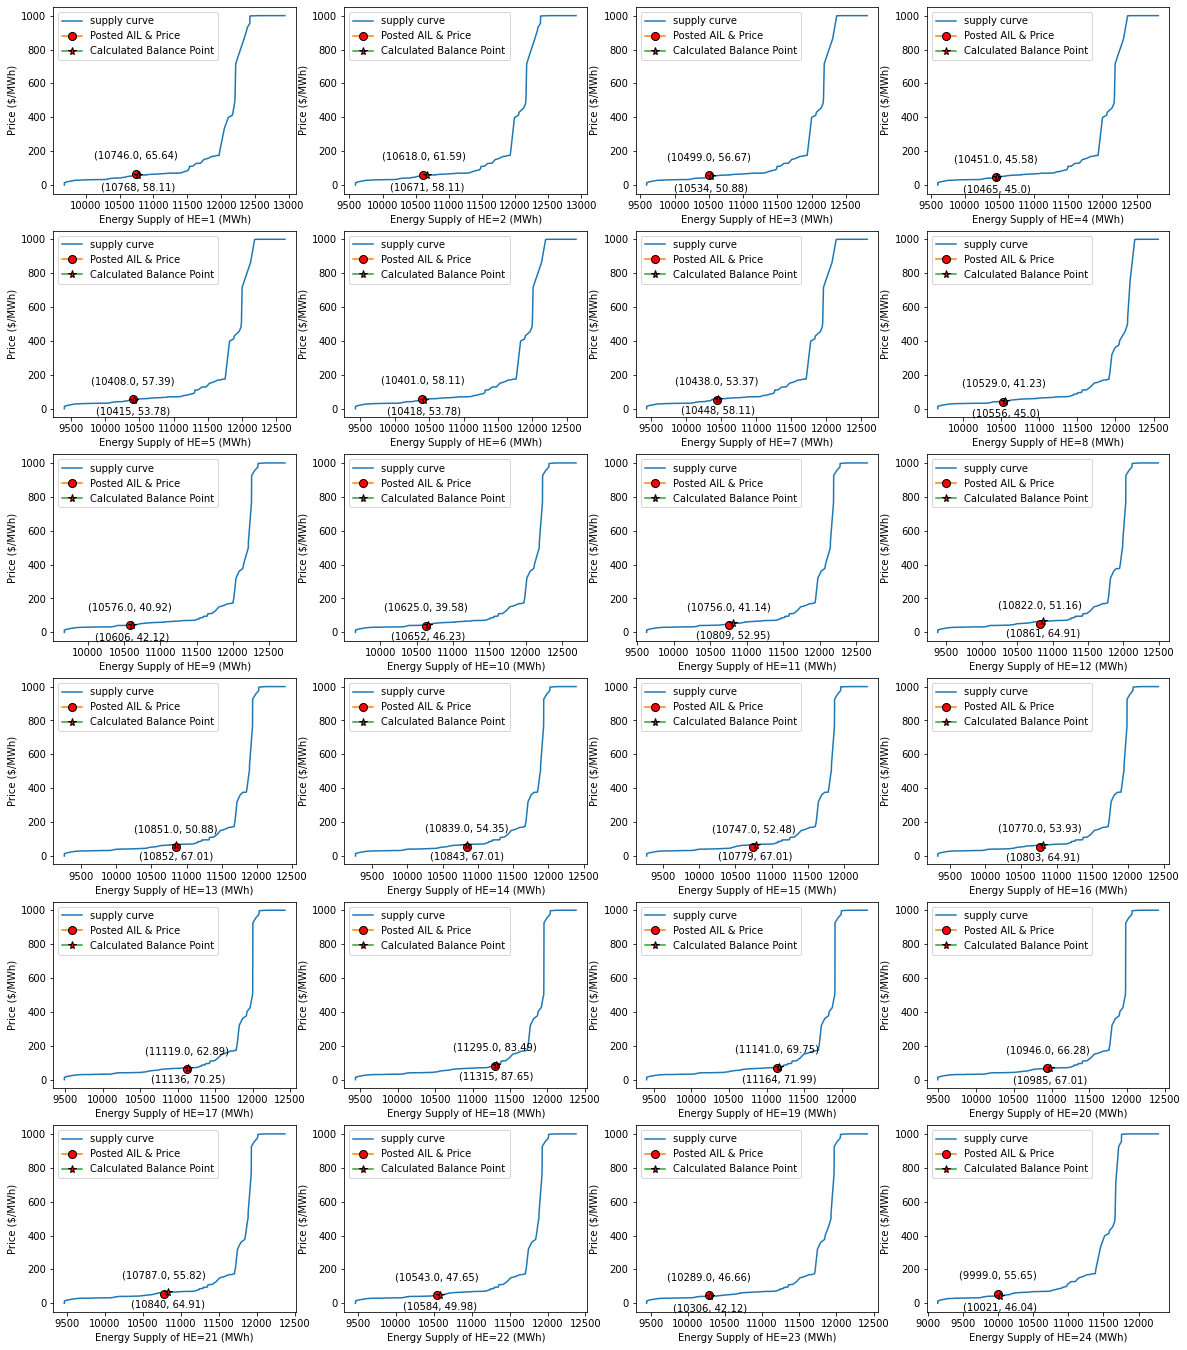

In [57]:
pm.draw_single_date_supply_curve(date='01/01/2022',supplyDf=df_mo, demandDf=df_pp)

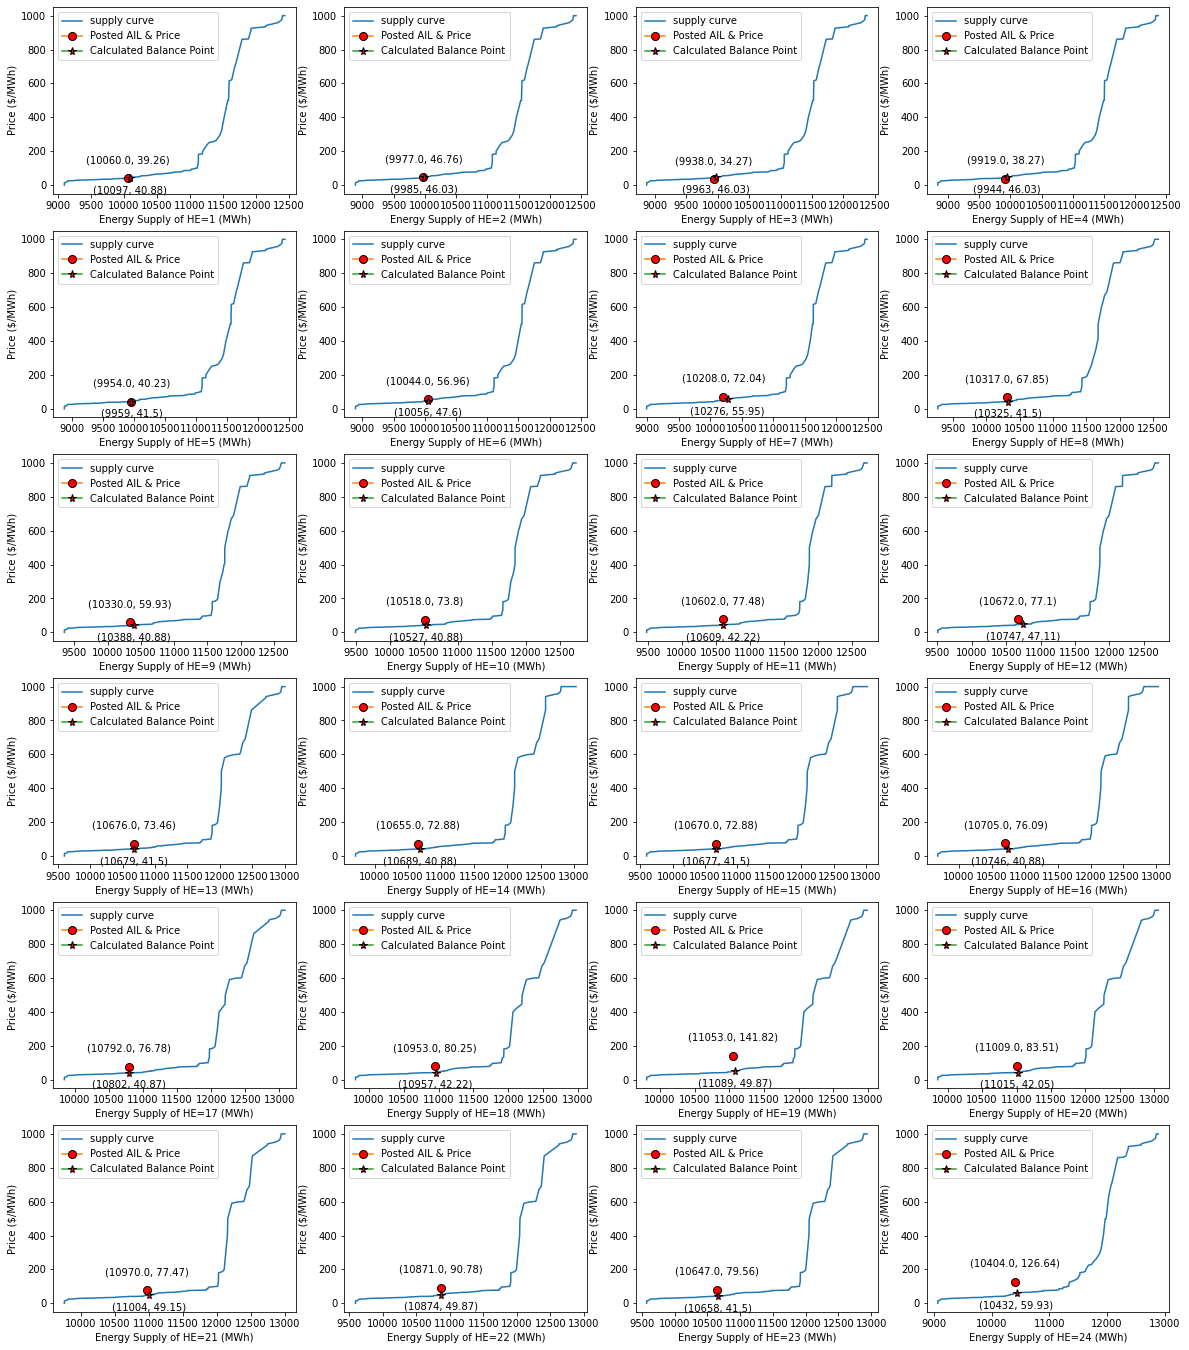

In [58]:
pm.draw_single_date_supply_curve(date='02/20/2022', supplyDf=df_mo, demandDf=df_pp)

# Collect SMP Dataset

In [ ]:
from math import perm
from time import sleep
from datetime import datetime
import requests
import re
import csv
import pytz
import logging
%cd ../data/

url = 'http://ets.aeso.ca/ets_web/ip/Market/Reports/CSMPriceReportServlet?contentType=csv'
mdt = pytz.timezone('America/Edmonton')
now = datetime.now(mdt).strftime('%Y-%m-%d-%H-%M-%S')
logging.basicConfig(filename='SystemMarginalPrice-{}.log'.format(now), level=logging.DEBUG, 
                    format='%(asctime)s %(levelname)s %(name)s %(message)s')
logger=logging.getLogger(__name__)

with open('SystemMarginalPrice-{}.csv'.format(now), 'a+', newline='') as csv_file:
    fieldnames = ['Date', 'HE', 'Price', 'Minute']
    output_writer = csv.DictWriter(
        csv_file, fieldnames=fieldnames, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    output_writer.writerow(
        {'Date': 'Date', 'HE': 'HE', 'Price': 'Price', 'Minute': 'Minute'})
    while True:
        obj = {'Date': datetime.now(mdt).strftime('%m/%d/%Y')}
        try:
          res = requests.get(url, verify=True)
          dataObj = re.search(
              r'Hour Ending (?P<HE>[\d]+) is \$(?P<Price>[\d]+\.[\d]+) as of (?P<Minute>[\d]+\:[\d]+)', res.text).groupdict()
          obj.update(dataObj)
          output_writer.writerow(obj)
          csv_file.flush()
        except requests.ConnectionError as conn_err:
          logger.error(conn_err)
        except AttributeError as attr_error:
          # when re couln't match and 'NoneType' object has no attribute 'groupdict'
          logger.error(attr_error)
        except PermissionError as perm_err:
          logger.error(perm_err)
        except BaseException as err:
          logger.error(err)
        sleep(60)